In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12b_vae.ipynb"
_nb_title = "MNIST용 변분 오토인코더"
_nb_message = """
Train a variational deep convolutional autoencoder on MNIST.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=MNIST%EC%9A%A9+%EB%B3%80%EB%B6%84+%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F12_generation%2F12b_vae.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12b_vae.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/12_generation/12b_vae.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/12_generation/12b_vae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>MNIST용 변분 오토인코더</h1>
Train a variational deep convolutional autoencoder on MNIST.


## GPU 활성화
이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다. 

코랩에서:
* 수정 → 노트 설정 메뉴로 이동
* 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
* https://console.cloud.google.com/ai-platform/notebooks 로 이동
* GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.9.2
Found GPU at: /device:GPU:0


In [3]:
# 라이브러리와 모듈을 임포트
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

## 시각화 유틸리티

In [4]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # 숫자의 n*n 2D 매니폴드를 표시
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # 잠재 공간에서 숫자 클래스의 2D 플롯에 해당하는 선형 간격 좌표
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters(encoder, data, labels, vae=True):
    # 잠재 공간에 숫자 클래스의 2D 플롯을 표시
    if vae:
      z_mean, _, _ = encoder.predict(data)
    else:
      z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10): # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(cx, cy, str(label), color="white", fontsize=25, fontweight="bold")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## 변분 오토인코더

잠재 차원의 평균과 분산을 샘플링한다는 점을 제외하면 [12a_autoencoder.ipynb](12a_autoencoder.ipynb)와 비슷하다.

케라스 유틸리티를 써서 MNIST 데이터를 로딩

In [5]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

11490434/11490434 [==============================] - 2s 0us/step


숫자를 인코딩하는 벡터를 샘플링하는 변분 인코더

In [6]:
class Sampling(layers.Layer):
    """(z_mean, z_log_var)를 사용해, 숫자를 인코딩하는 벡터 z를 샘플링."""

    def call(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

인코더는 입력에서 잠재 차원으로 이동하지만, 여기서는 출력이 여러 개이므로 함수형 스타일을 사용

In [7]:
latent_dim = 2 # 시각화를 쉽게 하기 위함

encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name="e_conv1")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name="e_conv2")(x)
x = layers.Flatten(name="e_flatten")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x) # 오토인코더 출력
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()(z_mean, z_log_var)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 e_conv1 (Conv2D)               (None, 14, 14, 32)   320         ['image_input[0][0]']            
                                                                                                  
 e_conv2 (Conv2D)               (None, 7, 7, 64)     18496       ['e_conv1[0][0]']                
                                                                                                  
 e_flatten (Flatten)            (None, 3136)         0           ['e_conv2[0][0]']                
                                                                                            

디코더는 잠재 차원에서 재구성된 이미지로 다시 이동

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,), name="d_input")
x = layers.Dense(7 * 7 * 64, activation="relu", name="d_d1")(latent_inputs)
x = layers.Reshape((7, 7, 64), name="d_d2")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="d_conv1")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same", name="d_conv2")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_input (InputLayer)        [(None, 2)]               0         
                                                                 
 d_d1 (Dense)                (None, 3136)              9408      
                                                                 
 d_d2 (Reshape)              (None, 7, 7, 64)          0         
                                                                 
 d_conv1 (Conv2DTranspose)   (None, 14, 14, 32)        18464     
                                                                 
 d_conv2 (Conv2DTranspose)   (None, 28, 28, 1)         289       
                                                                 
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


인코더의 손실은 KL 발산.

In [9]:
def kl_divergence(z_mean, z_log_var):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
encoder.add_loss(kl_divergence(z_mean, z_log_var))

오토인코더는 인코더와 디코더 블록으로 구성된다. Keras Functional 모델로 작성할 수 있다.

In [10]:
z_mean, z_log_var, z = encoder(encoder_inputs) # 이제 출력이 3개
decoder_output = decoder(z)
vae = keras.Model(encoder_inputs, decoder_output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               31364     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28161     
                                                                 
Total params: 59,525
Trainable params: 59,525
Non-trainable params: 0
_________________________________________________________________


전체 재구성 손실은 픽셀당 이진 손실의 합이다.

In [13]:
def reconstruction_loss(real, reconstruction):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(real, reconstruction), axis=(1, 2)
      )
  )

vae.compile(optimizer=keras.optimizers.Adam(), loss=reconstruction_loss, metrics=["mse"])

In [14]:
history = vae.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 5s 6ms/step - loss: 210.8562 - mse: 0.0668
Epoch 2/30
547/547 [==============================] - 3s 6ms/step - loss: 170.7318 - mse: 0.0511
Epoch 3/30
547/547 [==============================] - 3s 6ms/step - loss: 165.0361 - mse: 0.0485
Epoch 4/30
547/547 [==============================] - 3s 6ms/step - loss: 161.5321 - mse: 0.0467
Epoch 5/30
547/547 [==============================] - 3s 6ms/step - loss: 159.7160 - mse: 0.0458
Epoch 6/30
547/547 [==============================] - 4s 7ms/step - loss: 158.5432 - mse: 0.0453
Epoch 7/30
547/547 [==============================] - 3s 6ms/step - loss: 157.7399 - mse: 0.0449
Epoch 8/30
547/547 [==============================] - 3s 6ms/step - loss: 157.1098 - mse: 0.0445
Epoch 9/30
547/547 [==============================] - 4s 6ms/step - loss: 156.5744 - mse: 0.0443
Epoch 10/30
547/547 [==============================] - 4s 7ms/step - loss: 156.1034 - mse: 0.0440
Epoch 11/30
547/547 [========

1875/1875 [==============================] - 3s 1ms/step


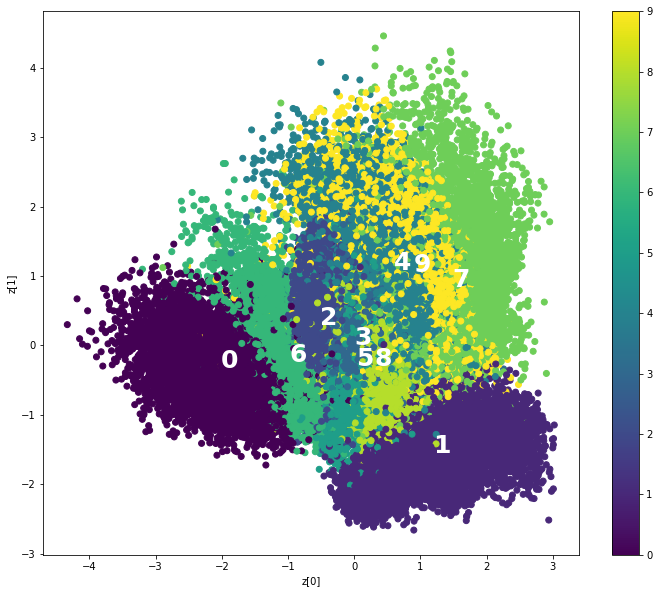

In [15]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train, vae=True)

1/1 [==============================] - 0s 15ms/step


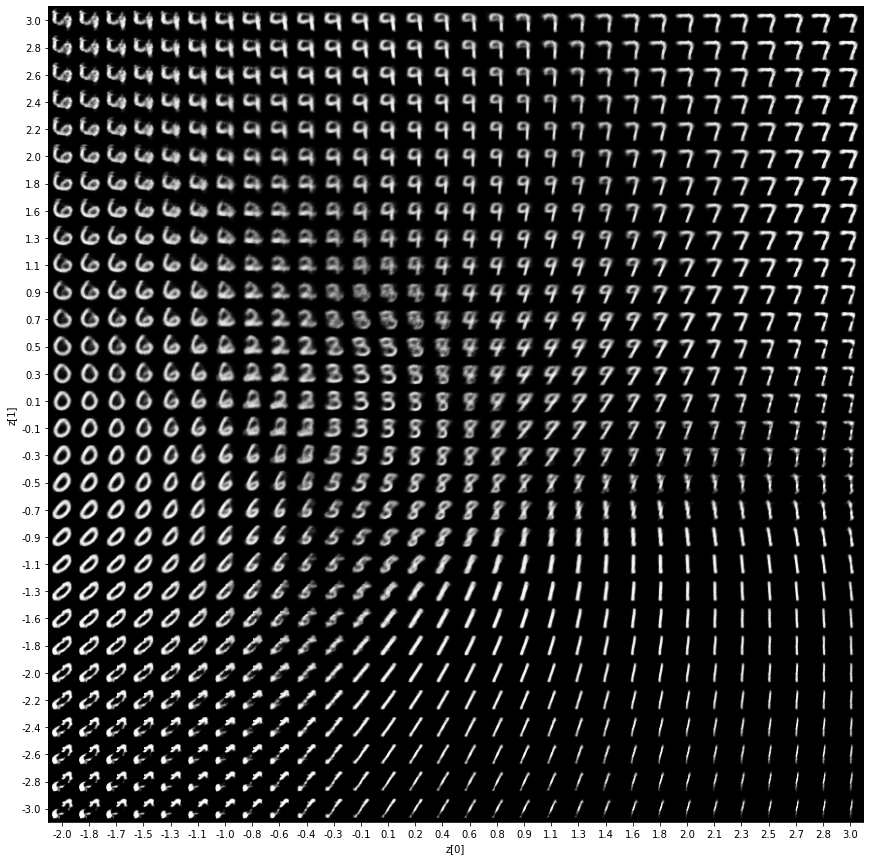

In [16]:
plot_latent_space(decoder, n=30, ranges=[-2, 3, -3, 3], figsize=15)

Copyright 2021 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.